In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
pathDatos = './Datos/'

In [3]:
df = pd.read_csv(f'{pathDatos}marketing_campaign.csv', sep='\t')
df.columns = df.columns.str.lower()
print(f'shape: {df.shape}')
df.head(2)

shape: (2240, 29)


,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,z_costcontact,z_revenue,response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0


In [4]:
# Eliminamos los registros duplicados del dataset.
df.drop_duplicates(inplace=True)

&nbsp;
### Generacion nuevas variables
---

In [5]:
# Informacion de cada una de las variables 
pd.read_table('./info_columns.txt', header=None).to_dict()[0]

{0: "ID: Customer's unique identifier",
 1: "Year_Birth: Customer's birth year",
 2: "Education: Customer's education level",
 3: "Marital_Status: Customer's marital status",
 4: "Income: Customer's yearly household income",
 5: "Kidhome: Number of children in customer's household",
 6: "Teenhome: Number of teenagers in customer's household",
 7: "Dt_Customer: Date of customer's enrollment with the company",
 8: "Recency: Number of days since customer's last purchase",
 9: 'Complain: 1 if the customer complained in the last 2 years, 0 otherwise',
 10: 'MntWines: Amount spent on wine in last 2 years',
 11: 'MntFruits: Amount spent on fruits in last 2 years',
 12: 'MntMeatProducts: Amount spent on meat in last 2 years',
 13: 'MntFishProducts: Amount spent on fish in last 2 years',
 14: 'MntSweetProducts: Amount spent on sweets in last 2 years',
 15: 'MntGoldProds: Amount spent on gold in last 2 years',
 16: 'NumDealsPurchases: Number of purchases made with a discount',
 17: 'AcceptedCmp1

A partir de estas variables vamos a eliminar aquellas variables que no van a ser utilizadas y vamos a generar nuevas variables a partir de las ya existentes

In [6]:
# Eliminamos aquellas variables que no se van a utilizar.
vars_remove = ['id', 'z_costcontact', 'z_revenue', 'response']
df.drop(vars_remove, axis=1, inplace=True)

# generamos una variable que nos diga la edad del cliente a partir del año de su cumpleaños (year_birth).
year = 2022
df['age'] = year - df['year_birth']
df.drop(['year_birth'], axis=1, inplace=True)

# unificamos valores en la variable marital_status.
df['marital_status'] = df['marital_status'].replace({'Alone':'Single', 'Absurd':'Single', 'YOLO':'Single', 'Together':'Married'})

# Creamos una variable que nos diga si el cliente vive solo o no
df['living_alone'] = np.where(df.marital_status == 'Married', 0, 1)

# Unificamos los valores de la variable education
df["education_level"] = df["education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})
df.drop(['education'], axis=1, inplace=True)

# A partir de las variables Kidhome, Teenhome generamos una nueva variable que nos diga el numero de hijos que hay en total.
df['sons'] = df.kidhome + df.teenhome
df['parents'] = np.where(df['sons'] > 0, 1, 0)

# A partir de la variable dt_customer obtenemos cuantos meses lleva el cliente con la compañia.
date_ = datetime.strptime('2022-08-01', '%Y-%m-%d')
df['dt_customer'] = pd.to_datetime(df['dt_customer'], format='%d-%m-%Y')
df['tenure_months'] = (round(((date_ - df.dt_customer) / np.timedelta64(1, 'D'))/30)).astype(int)
df.drop(['dt_customer'], axis=1, inplace=True)

# A partir de las variables que hacen referencia a la cantidad gastada en diferentes productos, generamos una nueva variable que nos indique la cantidad total gastada.
vars_mnt = [elem for elem in df.columns if elem.__contains__('mnt')]
df['total_amount_spent'] = df[vars_mnt].sum(axis=1)

# Generamos cuantas campañas ha aceptado el cliente, eliminamos las variables que hace referencia a cada campaña y solo usamos la nueva variable.
vars_accepted = [elem for elem in df.columns if elem.__contains__('accep')]
df['num_accepted_campaigns'] = df[vars_accepted].sum(axis=1)
df.drop(vars_accepted, axis=1, inplace=True)

# Generamos una variable que nos diga cuantas compras ha realizado
vars_purchases = [elem for elem in df.columns if elem.__contains__('num')]
df['total_num_purchases'] = df[vars_purchases].sum(axis=1)

# Gasto promedio de los clientes
df['avg_purchases'] = df['total_amount_spent'] / df['total_num_purchases']
df['avg_purchases'].replace([np.inf, -np.inf], 0, inplace=True)

In [7]:
print(f'shape despues de la generacion y eliminacion de variables: {df.shape}')
df.head()

shape despues de la generacion y eliminacion de variables: (2240, 27)


,marital_status,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,complain,age,living_alone,education_level,sons,parents,tenure_months,total_amount_spent,num_accepted_campaigns,total_num_purchases,avg_purchases
0,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,65,1,Graduate,0,0,121,1617,0,32,50.531250
1,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,68,1,Graduate,2,1,102,27,0,11,2.454545
2,Married,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,57,0,Graduate,0,0,109,776,0,25,31.040000
3,Married,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,38,0,Graduate,1,1,103,53,0,14,3.785714
4,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,41,0,Postgraduate,1,1,104,422,0,24,17.583333


In [8]:
def hist_boxplot(var, size=(17, 8), df=df):
    
    fig = plt.figure(figsize=size)
    grid = GridSpec(nrows=2, ncols=1, figure=fig)
    ax0 = fig.add_subplot(grid[0, :])
    ax0.set_title(f'Histogram y BoxPlot de {var}')
    sns.distplot(df[var], ax=ax0, color='deepskyblue', kde=False)

    ax1 = fig.add_subplot(grid[1, :])
    plt.axis('off')
    sns.boxplot(x=df[var], ax=ax1, color='deepskyblue')
    plt.show()
    
    
def hist_varCategorical(col, size=(22, 8), df=df):
    
    def __add_label(ax, xs, ys):
        for x,y in zip(xs,ys):
            label = "{:.0f}".format(y)
            ax.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center
    
    df_plt = df.copy()
    df_plt[col] = df_plt[col].astype(str)
    observation_values = list(df_plt[col].value_counts().index)
    total_observation_values = list(df_plt[col].value_counts())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=size)
    sns.histplot(df_plt[col], ax=ax1)
    ax2.pie(total_observation_values, labels= observation_values, autopct = '%1.1f%%', startangle = 110, labeldistance = 1.1)
    ax2.axis("equal") # Equal aspect ratio ensures that pie is drawn as a circle.
    __add_label(ax1, list(df_plt[col].value_counts().to_dict().keys()), list(df_plt[col].value_counts().to_dict().values()))
    ax1.set_title(f'histograma variable {col}')
    ax2.set_title(col)
    ax2.legend()
    plt.show()
    
    
def comparative_variables(col, size=(22, 8), df=df):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=size)
    df.groupby(col)[['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']].sum().sort_values(by='mntsweetproducts' , ascending=False).plot(kind='bar', ax=ax1)
    ax1.set_title(f'Cantidad gastada en diferentes productos por {col}')
    ax1.tick_params(axis='x', rotation=360)


    df[[col,'total_amount_spent']].groupby(col).sum().sort_values(by='total_amount_spent', ascending=False).plot(kind='bar',legend=None, ax=ax2)
    ax2.set_title(f'Gasto total por {col}')
    ax2.tick_params(axis='x', rotation=360)

    plt.show()


#### Education_level

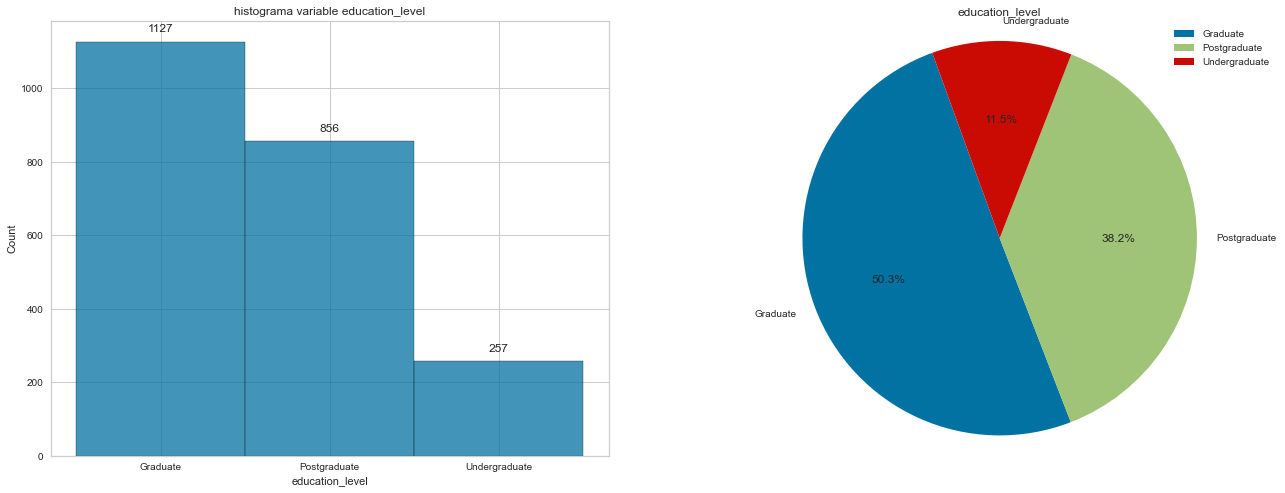

In [9]:
hist_varCategorical('education_level')

#### marital_status

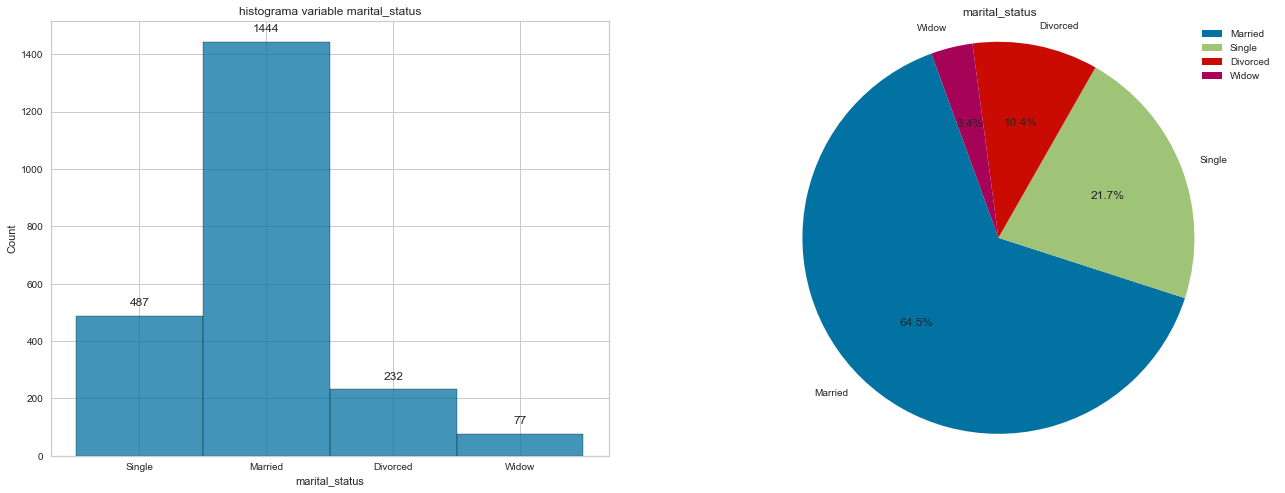

In [10]:
hist_varCategorical('marital_status')

#### Living_alone

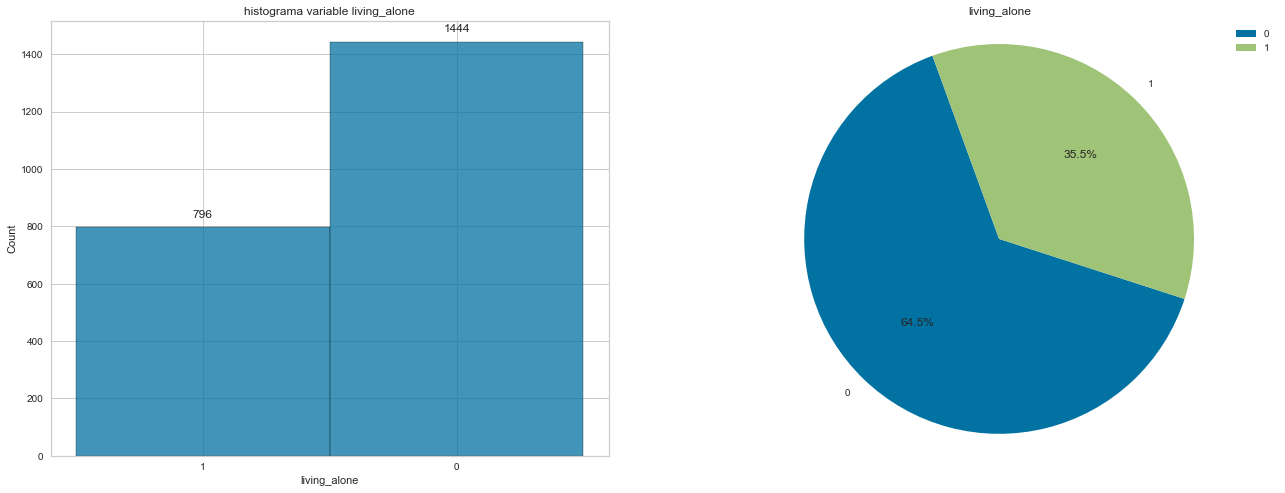

In [11]:
hist_varCategorical('living_alone')

#### sons

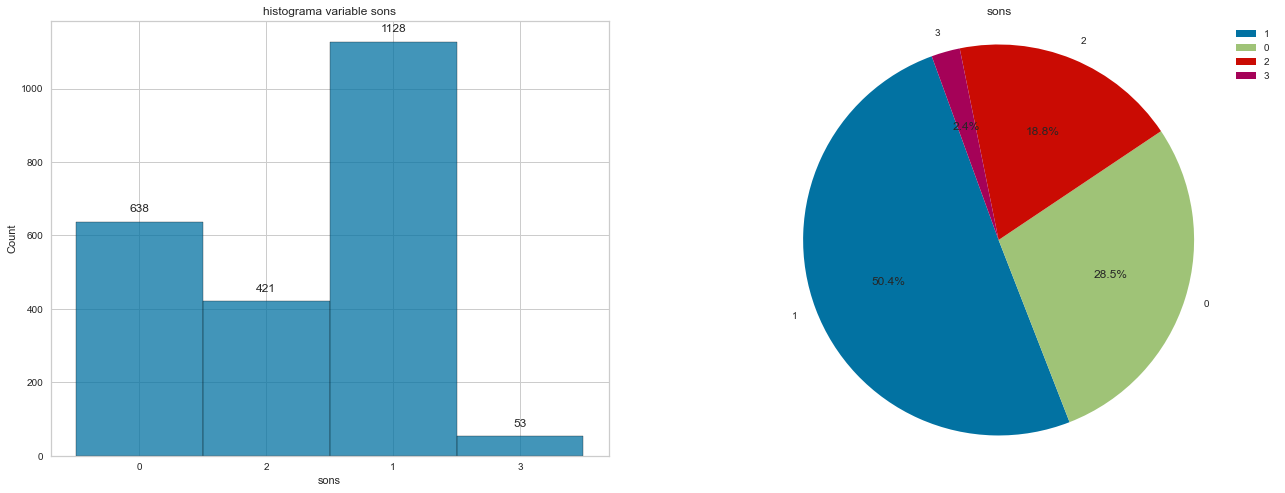

In [12]:
hist_varCategorical('sons')

#### Parents

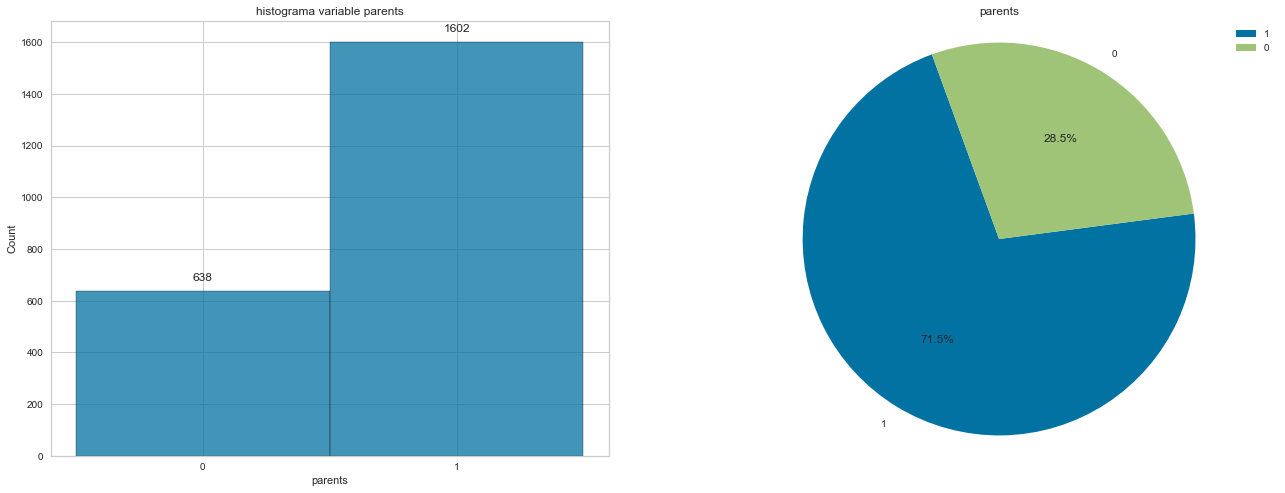

In [13]:
hist_varCategorical('parents')

#### income

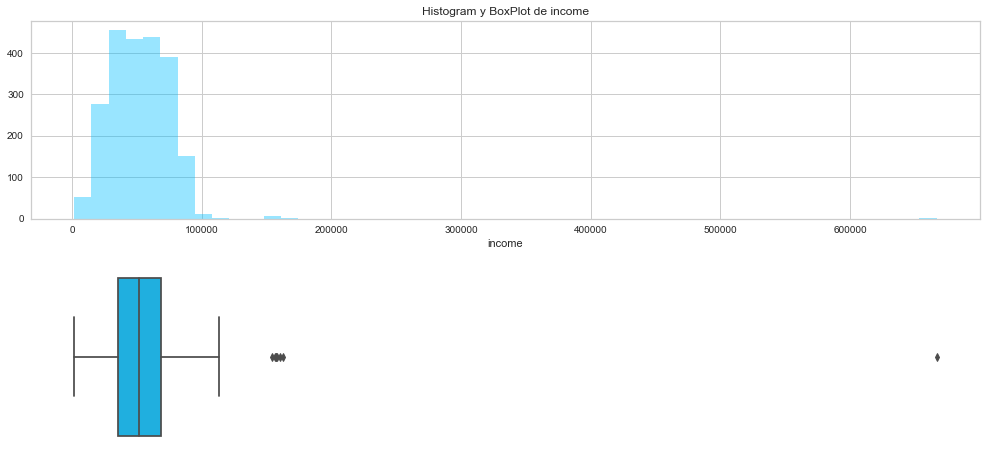

In [14]:
hist_boxplot('income')

#### recency

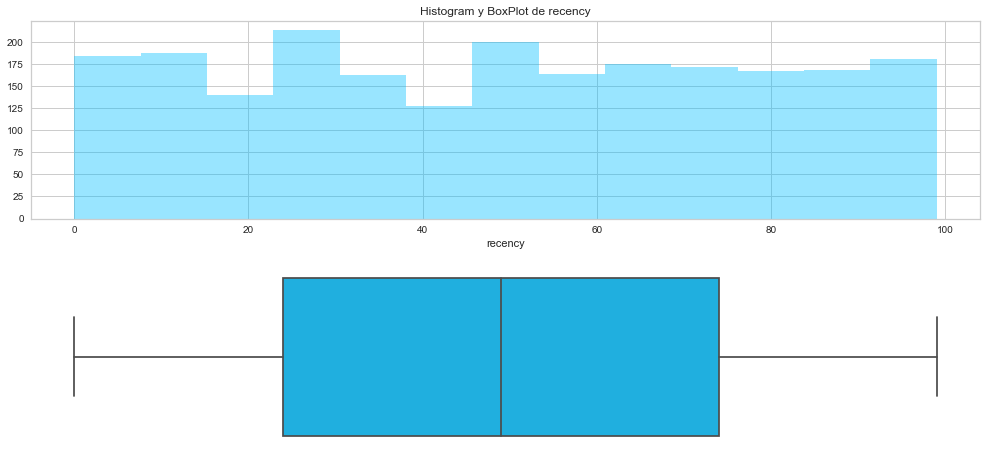

In [15]:
hist_boxplot('recency')

#### Age

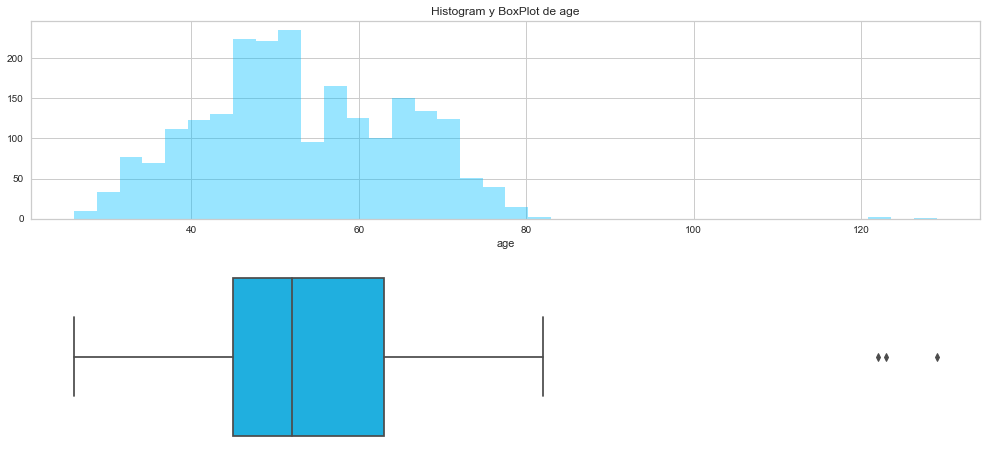

In [16]:
hist_boxplot('age')

#### tenure_months

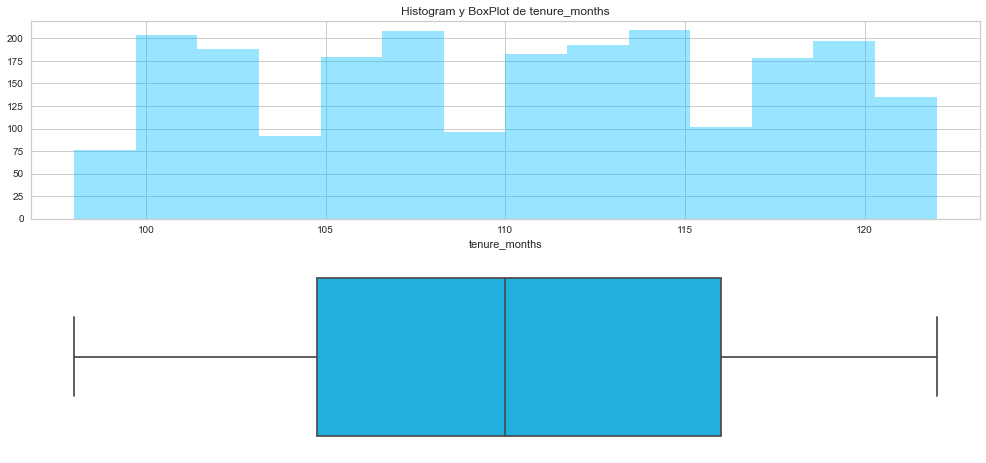

In [17]:
hist_boxplot('tenure_months')

#### total_amount_spent

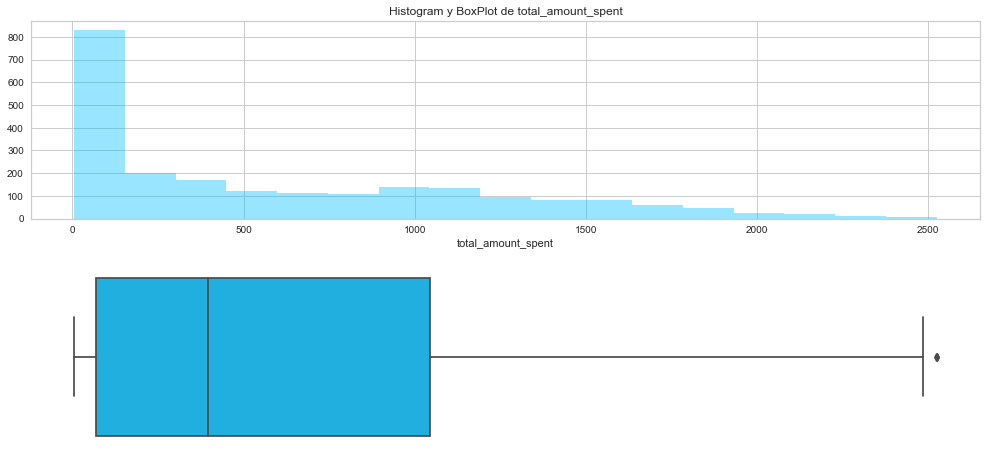

In [18]:
hist_boxplot('total_amount_spent')

#### num_accepted_campaigns

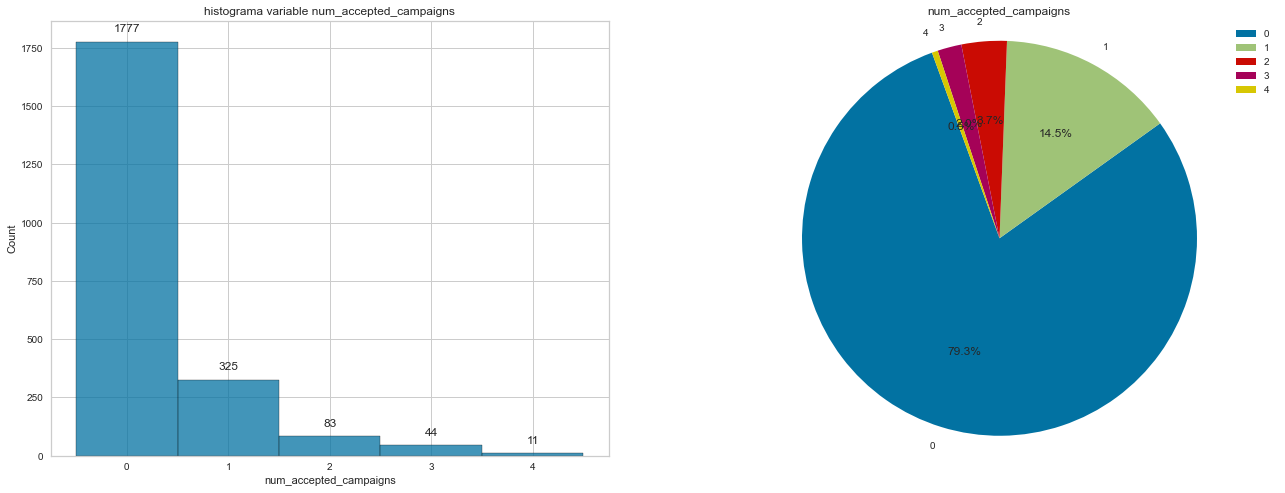

In [19]:
hist_varCategorical('num_accepted_campaigns')

#### avg_purchases

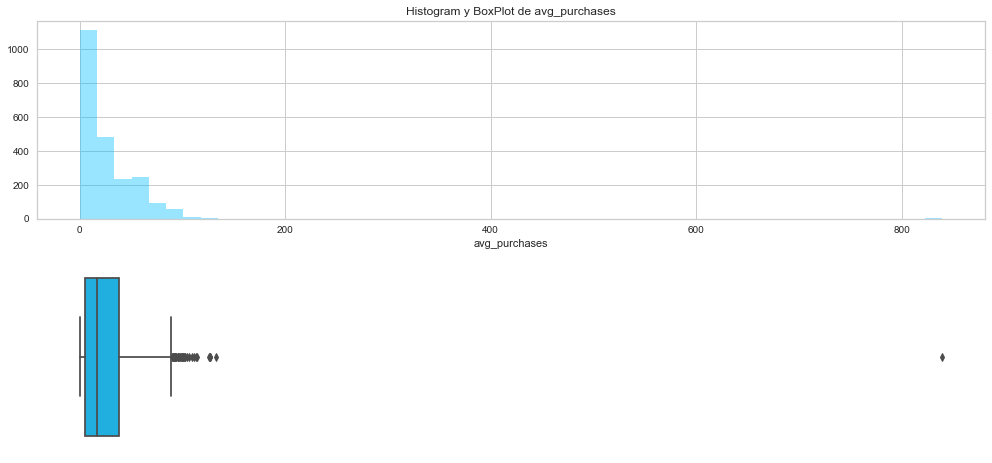

In [21]:
hist_boxplot('avg_purchases')

#### Comparativa entre variables

<Figure size 576x396 with 0 Axes>

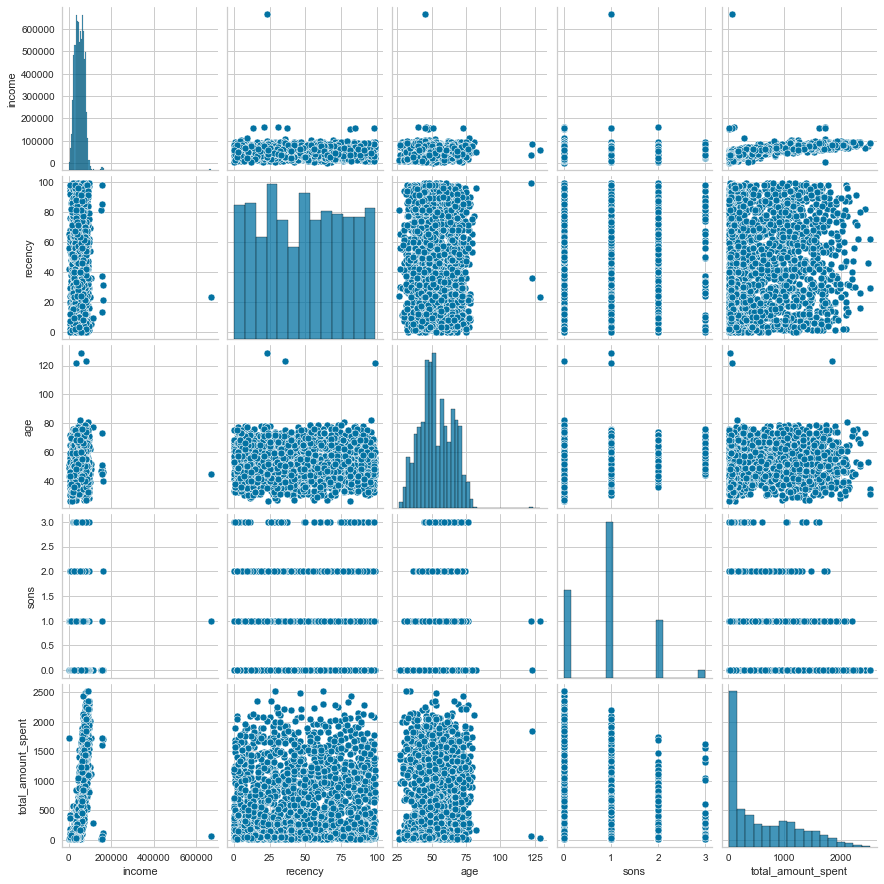

In [22]:
To_Plot = [ "income", "recency", "age", 'sons', 'total_amount_spent']
plt.figure()
sns.pairplot(df[To_Plot], palette= (["#682F2F","#F3AB60"]))
plt.show()

#### Analisis variable kidhome


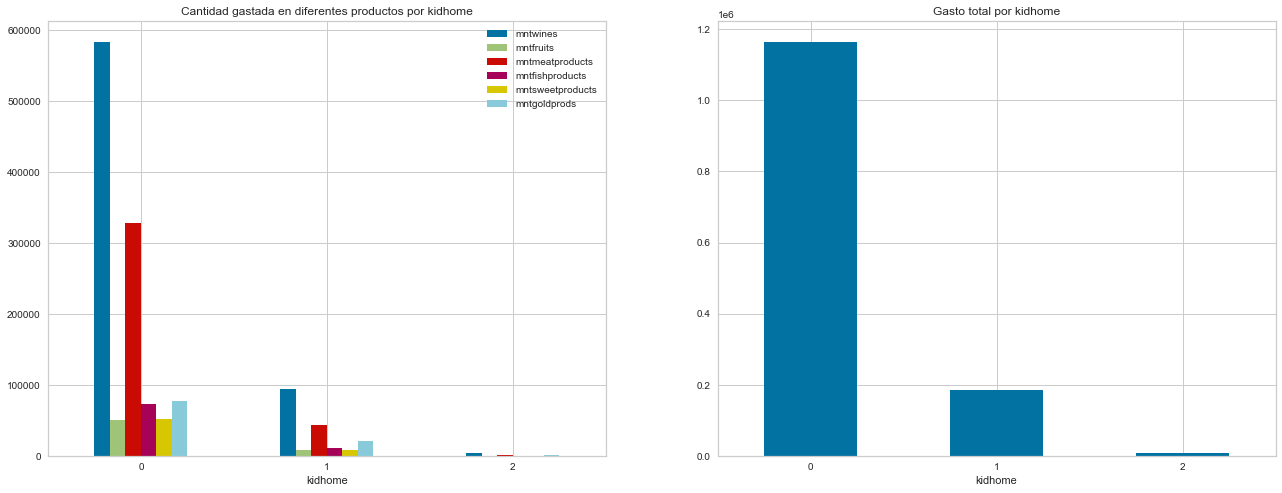

#### Analisis variable teenhome


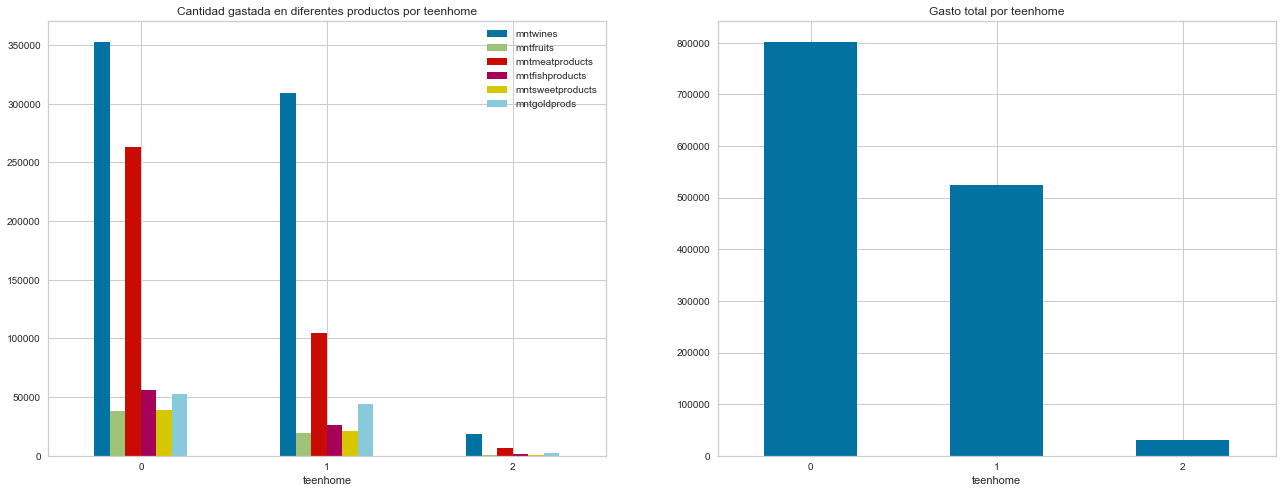

#### Analisis variable education_level


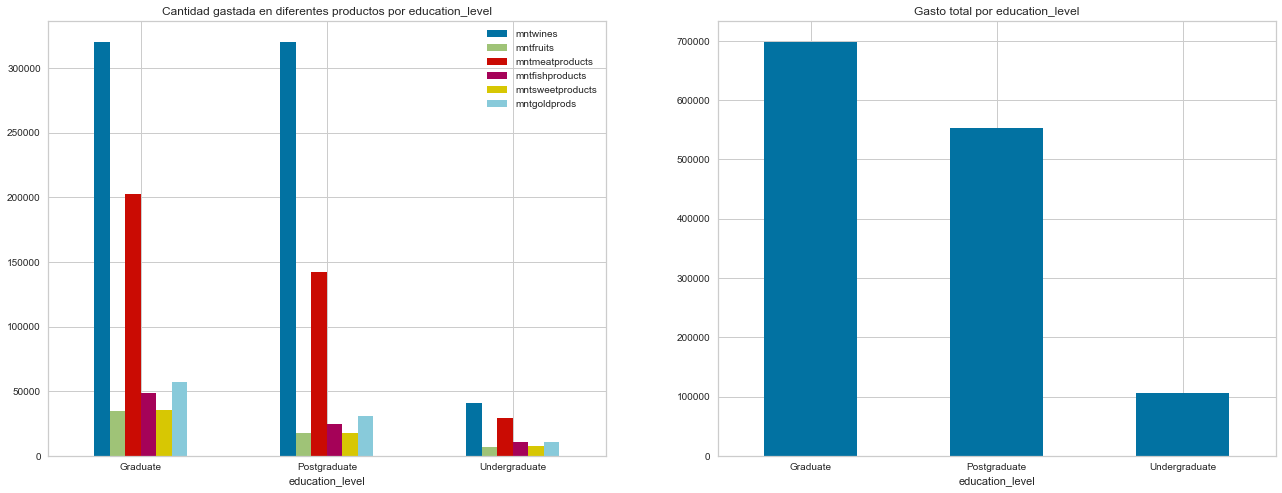

#### Analisis variable marital_status


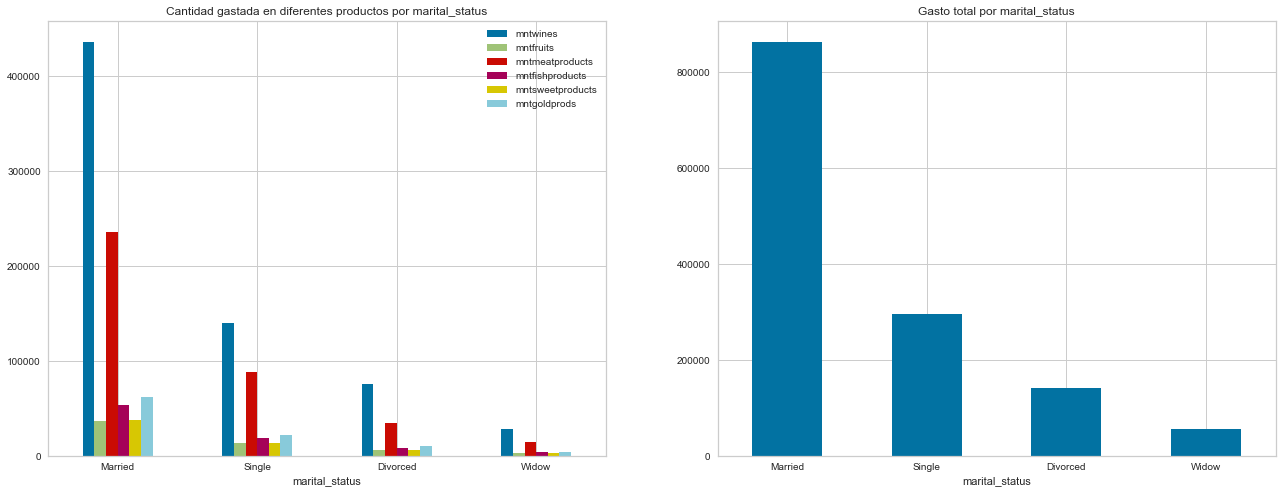

#### Analisis variable living_alone


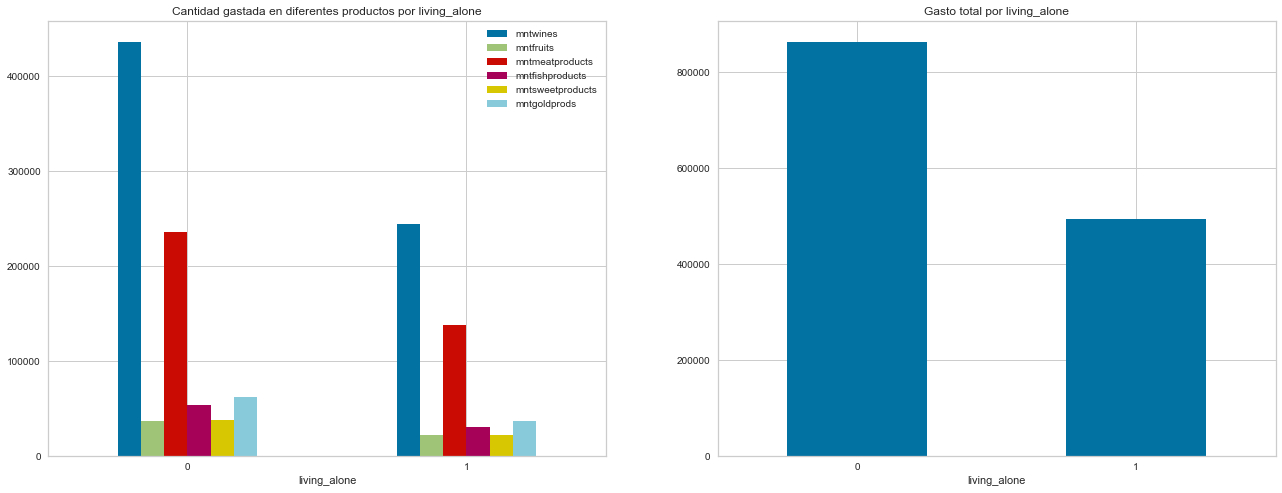

#### Analisis variable sons


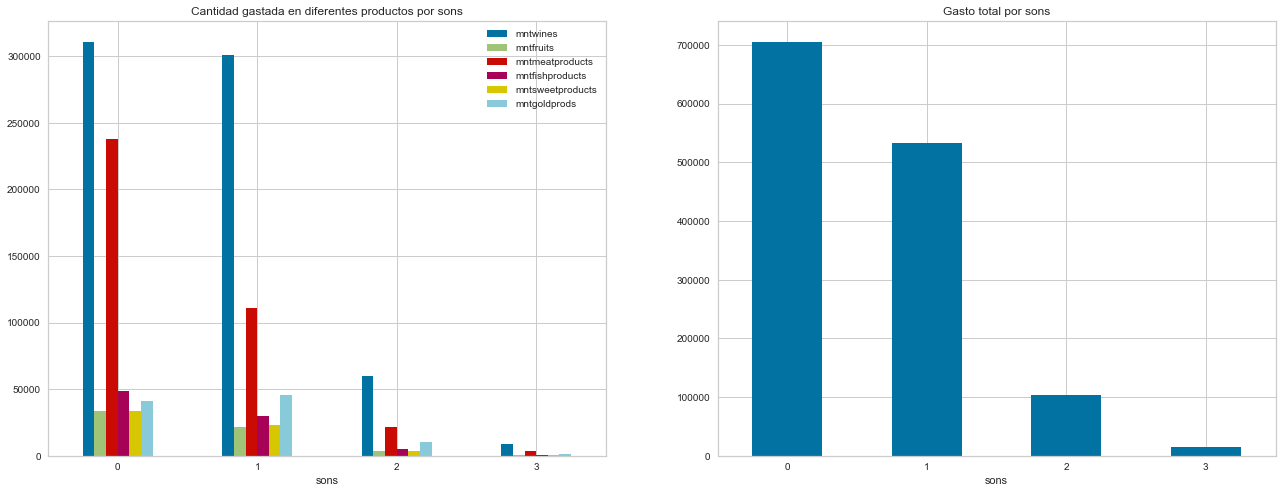

In [23]:
for col in ['kidhome','teenhome','education_level','marital_status','living_alone','sons']:
    print(f'#### Analisis variable {col}')
    comparative_variables(col)

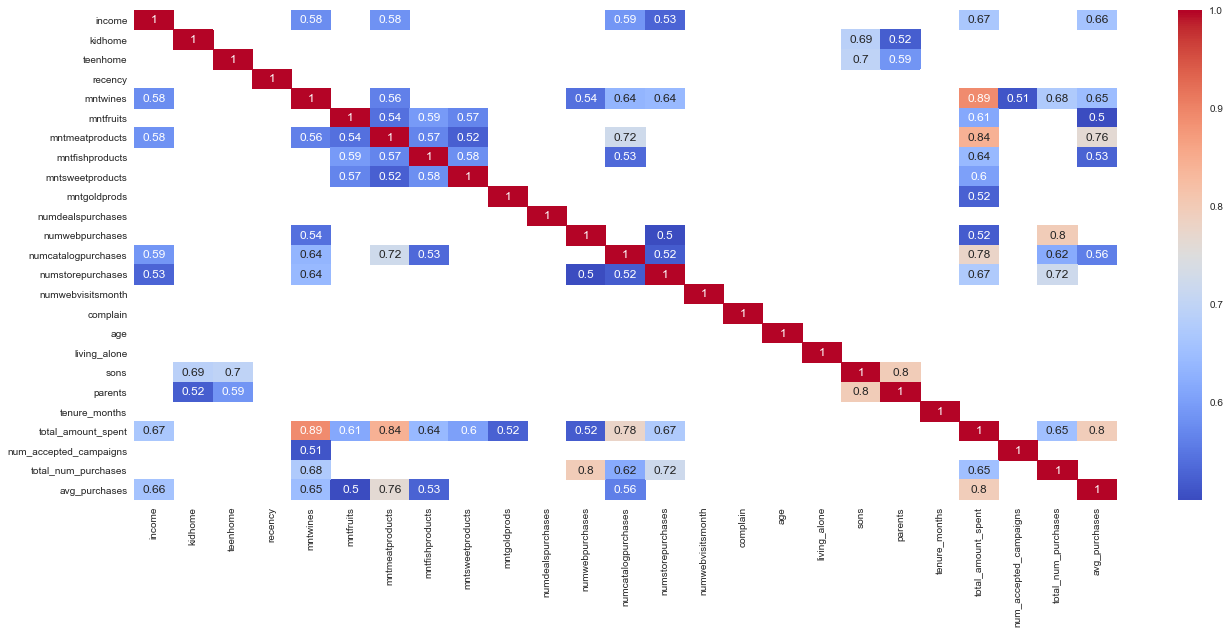

In [24]:
corr = df.corr()
plt.figure(figsize = (22,9))
sns.heatmap(data=corr[corr>0.5], annot=True, cmap='coolwarm')
plt.show()

### Eliminacion de los outliers

In [25]:
# Eliminamos los outliers que nos encontramos en las variables age, income y avg_purchases
df = df[(df["age"]<90)]
df = df[(df["income"]<600000)]
df = df[(df["avg_purchases"]<150)]
print(f'shape: {df.shape}')

shape: (2212, 27)


&nbsp;
## Variables para modelo
---

De todas las variables que tenemos solo cogemos aquellas que nos aporten información de cómo es el cliente en cuanto a su comportamiento de consumo.

In [26]:
varsToModel = ['income', 'avg_purchases', 'total_amount_spent', 'total_num_purchases']
df_subset = df[varsToModel].copy()
print(f'shape df_subset: {df_subset.shape}')

shape df_subset: (2212, 4)


&nbsp;
## Feature Engineering
---

### Imputacion de valores perdidos

In [27]:
df_subset.isna().sum()

income                 0
avg_purchases          0
total_amount_spent     0
total_num_purchases    0
dtype: int64

In [28]:
print(f'El numero de valores perdidos es {df_subset.isna().sum().sum()} por lo que no vamos a realizar ninguna imputacion')

El numero de valores perdidos es 0 por lo que no vamos a realizar ninguna imputacion


### Generacion de dummies

In [29]:
varsCategorical = df_subset.columns[df_subset.dtypes == 'object'].tolist()
print(f'Numero de variables categoricas: {len(varsCategorical)}')

Numero de variables categoricas: 0


In [30]:
if len(varsCategorical) > 0:
    for var in varsCategorical:
        df_subset = pd.get_dummies(df_subset, columns=[var])
df_subset.head(2)

,income,avg_purchases,total_amount_spent,total_num_purchases
0,58138.0,50.531250,1617,32
1,46344.0,2.454545,27,11


### Escalado de los datos

Ya que vamos a utilizar un algoritmo basado en distancias debemos de realizar un escalado de los datos para tener todas las variables en la misma escala de valores.

In [31]:
ds = df_subset.copy()
scaler = StandardScaler()
scaler.fit(ds)
df_sc = pd.DataFrame(scaler.transform(ds), columns=ds.columns)
print("Todas las variables han sido escaladas")
print(f'shape df_sc: {df_sc.shape}')
df_sc.head(2)

Todas las variables han sido escaladas
shape df_sc: (2212, 4)


,income,avg_purchases,total_amount_spent,total_num_purchases
0,0.287105,1.014573,1.676245,1.540895
1,-0.260882,-0.938133,-0.963297,-1.275682


&nbsp;
## Desarrollo del modelo
---

### KMeans

Metodo del codo para determinar el numero de clusters:


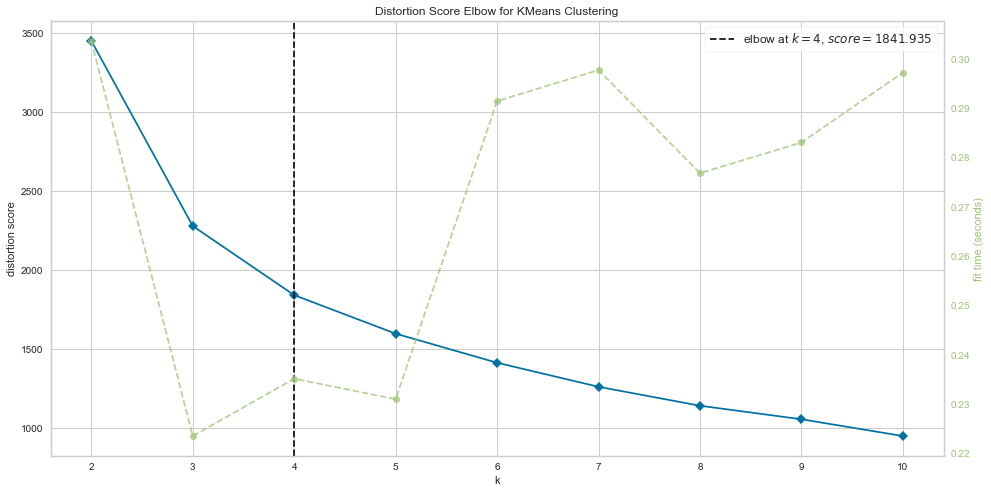

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
print('Metodo del codo para determinar el numero de clusters:')
plt.figure(figsize=(16, 8))
Elbow_M = KElbowVisualizer(KMeans(random_state=13), k=10)
Elbow_M.fit(df_sc)
Elbow_M.show()

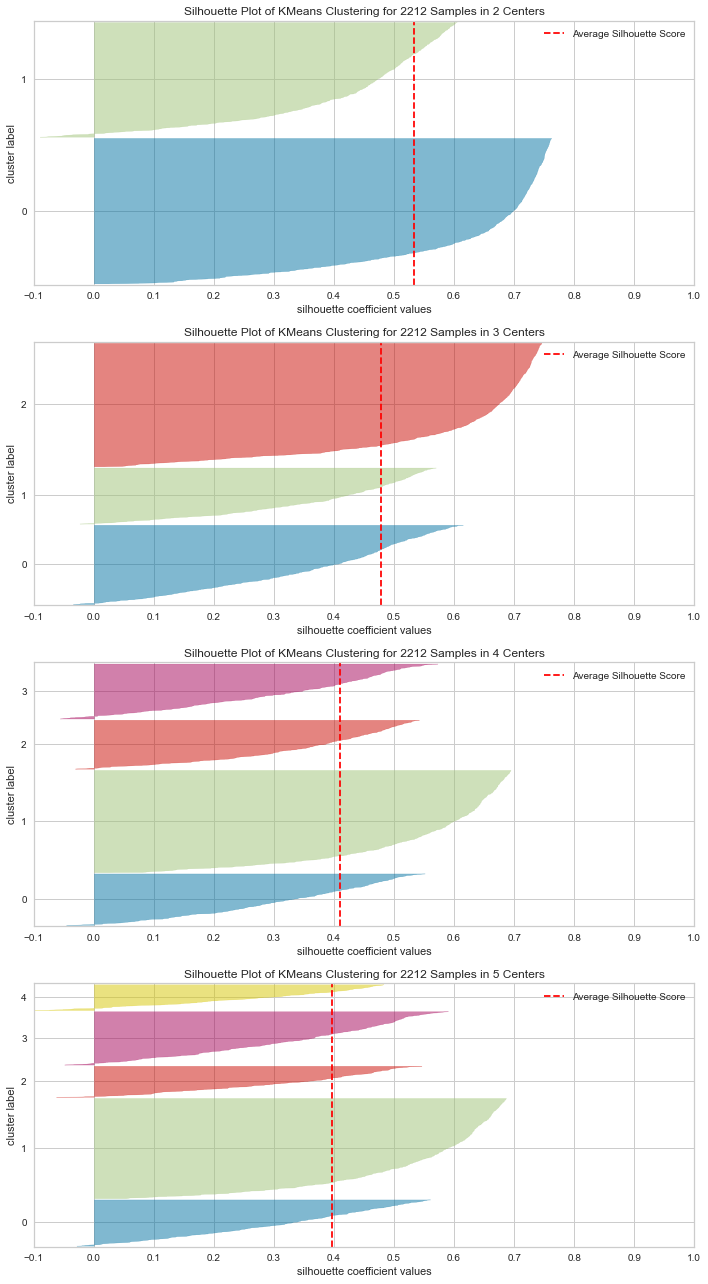

In [33]:
k_range = range(2, 6)
fig, axes = plt.subplots(4, 1, figsize=(10, 18))

for i in k_range:   
    model = KMeans(i, init='k-means++', n_init=100, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=axes[i-2])
    visualizer.fit(df_sc)
    visualizer.finalize()
    axes[i-2].set_xlim(-0.1, 1)
    
plt.tight_layout()

Tras utilizar el metodo del codo para determinar el numero de cluster, vemos que el numero optimo de clusters que debemos de coger es de 4.

In [34]:
# Ejecutamos el modelo kmeans con 4 cluster y generamos esta nueva variable de "Clusters" en el dataset "df"
kmeans = KMeans(n_clusters=4, random_state=13)
df['Clusters'] = kmeans.fit_predict(df_sc) + 1
df.head(2)

,marital_status,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,complain,age,living_alone,education_level,sons,parents,tenure_months,total_amount_spent,num_accepted_campaigns,total_num_purchases,avg_purchases,Clusters
0,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,65,1,Graduate,0,0,121,1617,0,32,50.531250,1
1,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,68,1,Graduate,2,1,102,27,0,11,2.454545,2


In [35]:
print(f'Silhouette Score: {silhouette_score(df_sc, kmeans.fit_predict(df_sc))}')

Silhouette Score: 0.40978613554325916


&nbsp;
## Analisis Clusters
---

In [36]:
def pie_plot(col, size=(8, 6), df=df):
    
    fig, ax = plt.subplots(figsize=size)

    observation_values = list(df[col].value_counts().index)
    total_observation_values = list(df[col].value_counts())
    ax.pie(total_observation_values, labels= observation_values, autopct = '%1.1f%%', startangle = 110, labeldistance = 1.1)
    ax.axis("equal") # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title(col)
    plt.legend()
    plt.show()
    
    
def boxplot_per_cluster(var_y, var_x='Clusters', size=(18, 8), df=df):
    plt.figure(figsize=size)
    pl=sns.boxplot(y=df[var_y],x=df[var_x], order=sorted(df[var_x].unique().tolist()))
    pl.set_title(f"Distribucion variable {var_y} por cluster")
    plt.show()
    
    
def scaterplot_per_cluster(var_x, var_y, var_hue='Clusters', size=(17.6, 8), df=df):
    plt.figure(figsize=size)
    sns.scatterplot(x=var_x, y=var_y, hue=var_hue, data=df)
    plt.title(f'Scatterplot por cluster de la variable {var_x} y {var_y}')
    plt.show()
    

def countplot_per_cluster(var_x, var_hue='Clusters', df=df):
    plt.figure(figsize=(18, 8))
    sns.countplot(data=df, x=var_x, hue=var_hue)
    plt.title(f'Distribucion de la variable {var_x} por cluster')
    plt.show()
    

def varplot_per_cluster(var_y, size=(18, 8), df=df):
    plt.figure(figsize=size)
    sns.barplot(x='Clusters', y=var_y, data=df)
    plt.show()

In [38]:
fig = px.scatter_3d(df, x="income", y="total_amount_spent", z="total_num_purchases", color='Clusters', width=800, height=800)
fig.show()

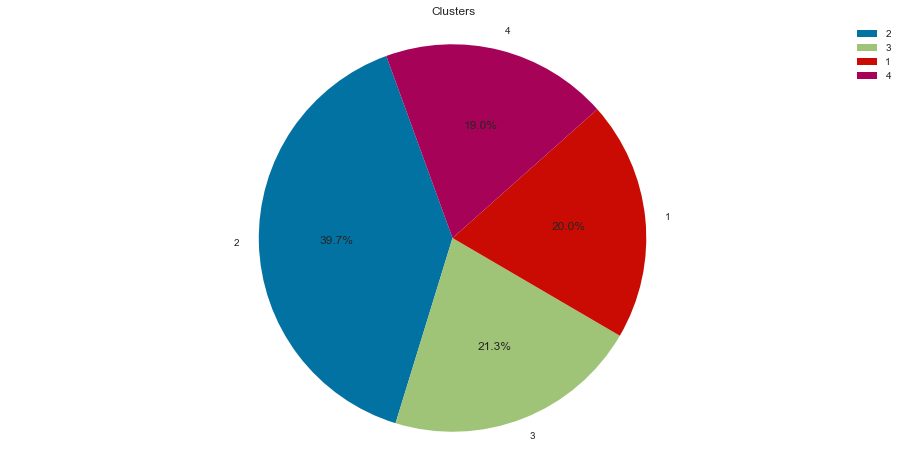

In [40]:
pie_plot('Clusters', size=(16, 8), df=df)

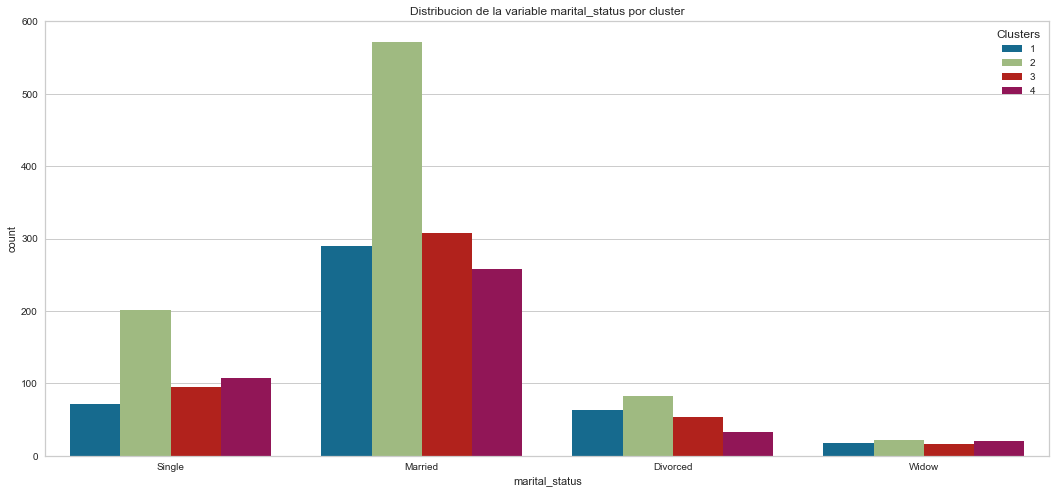

In [41]:
countplot_per_cluster('marital_status')

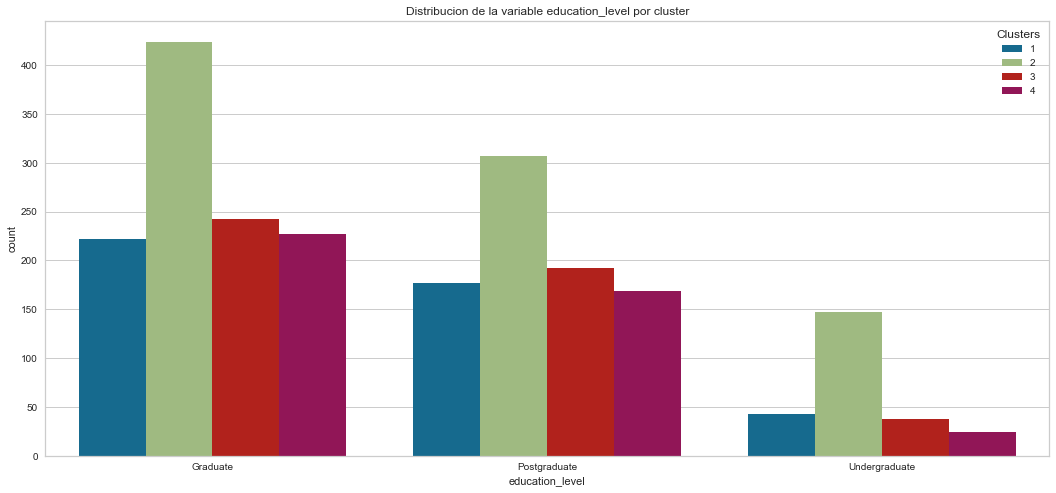

In [42]:
countplot_per_cluster('education_level')

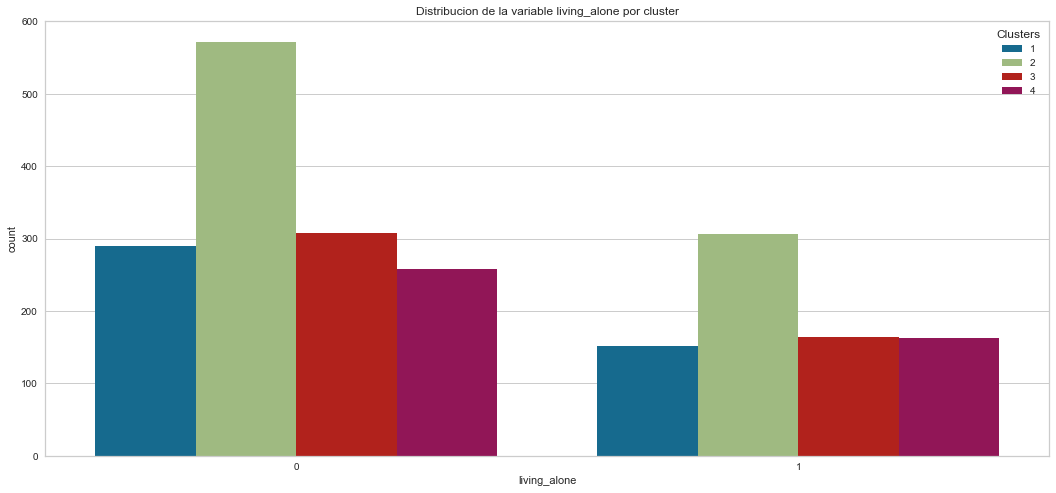

In [43]:
countplot_per_cluster('living_alone')

,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth
Clusters,,,,,
1,1408,3100,2189,4206,2308
2,1581,1603,365,2638,5631
3,1659,2364,934,2839,2762
4,494,1976,2423,3161,1070


<AxesSubplot:xlabel='Clusters'>

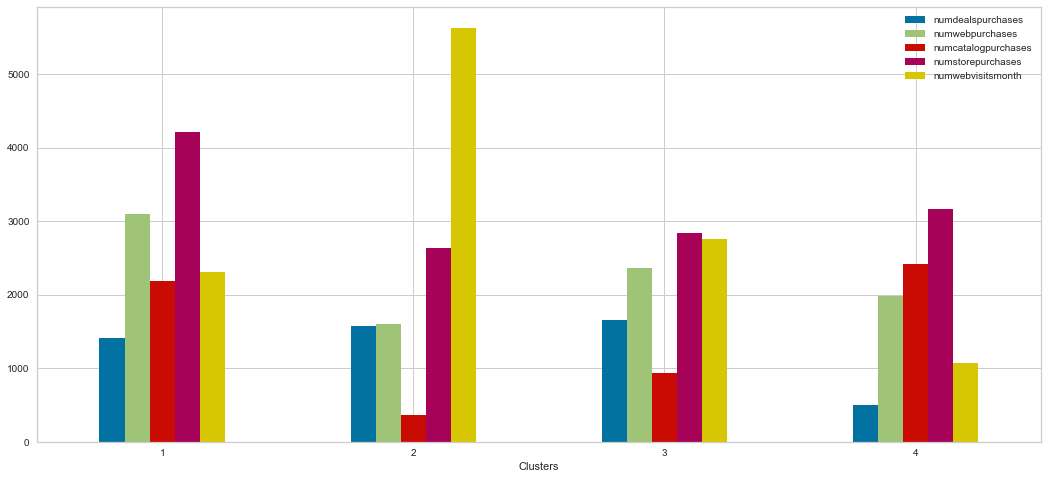

In [44]:
display(df.groupby('Clusters')[['numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']].sum())
df.groupby('Clusters')[['numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']].sum().plot(kind='bar', figsize=(18,8), rot=0)

In [57]:
df.total_num_purchases.mean()

20.51130198915009

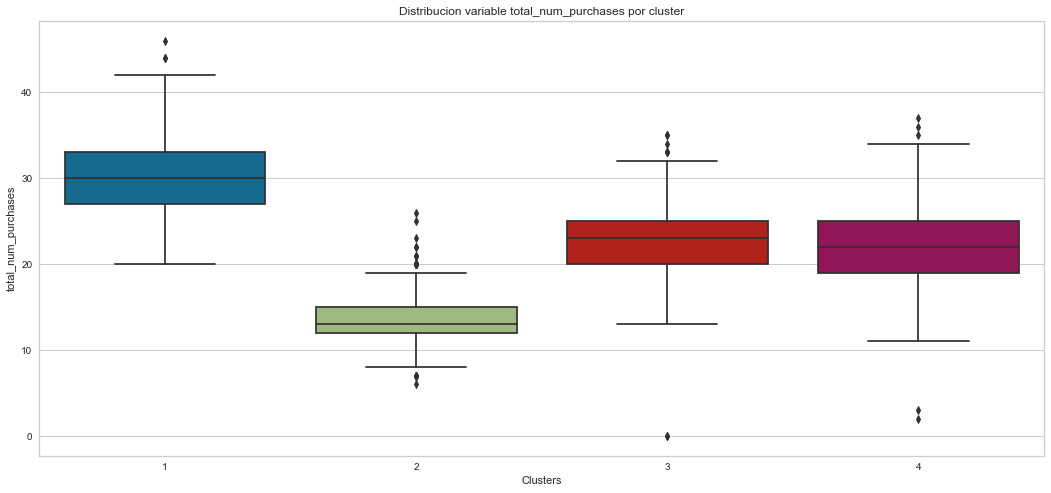

In [45]:
boxplot_per_cluster('total_num_purchases')

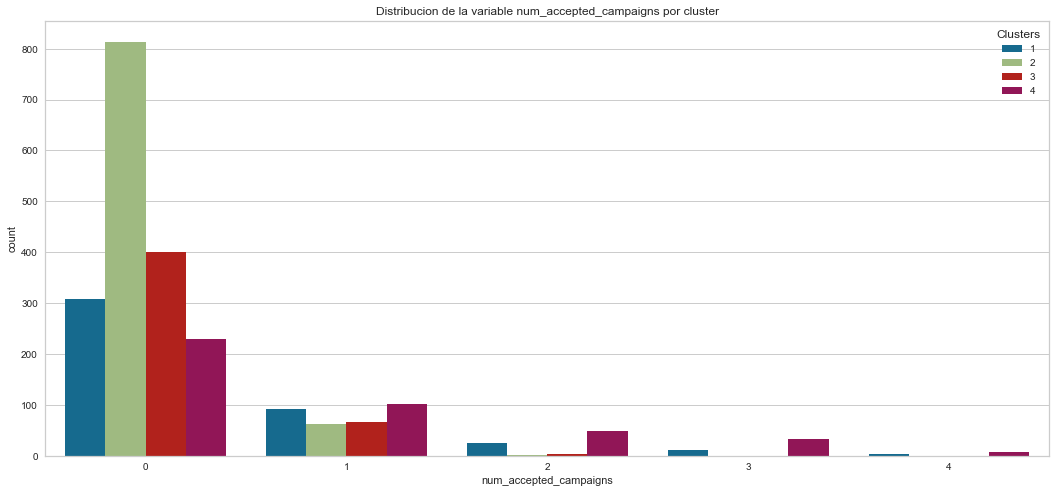

In [46]:
countplot_per_cluster('num_accepted_campaigns')

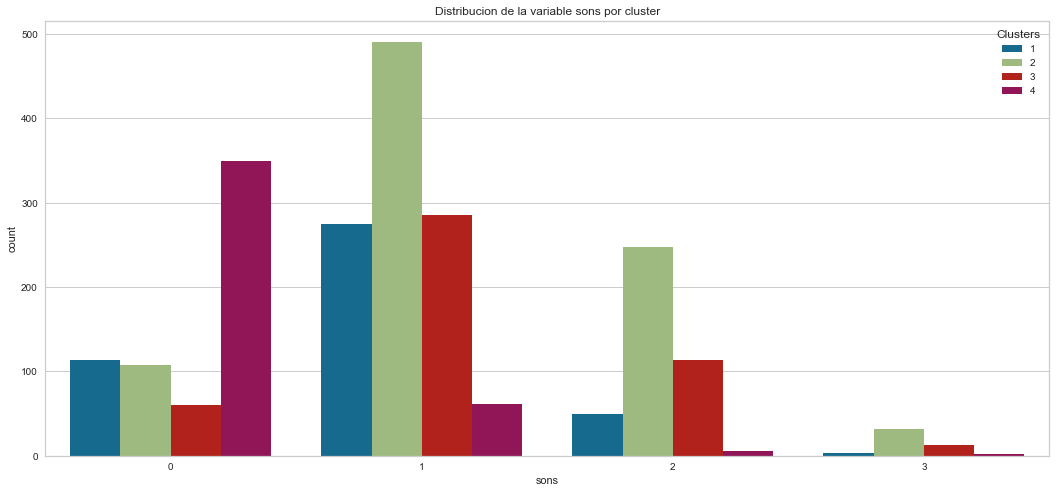

In [47]:
countplot_per_cluster('sons')

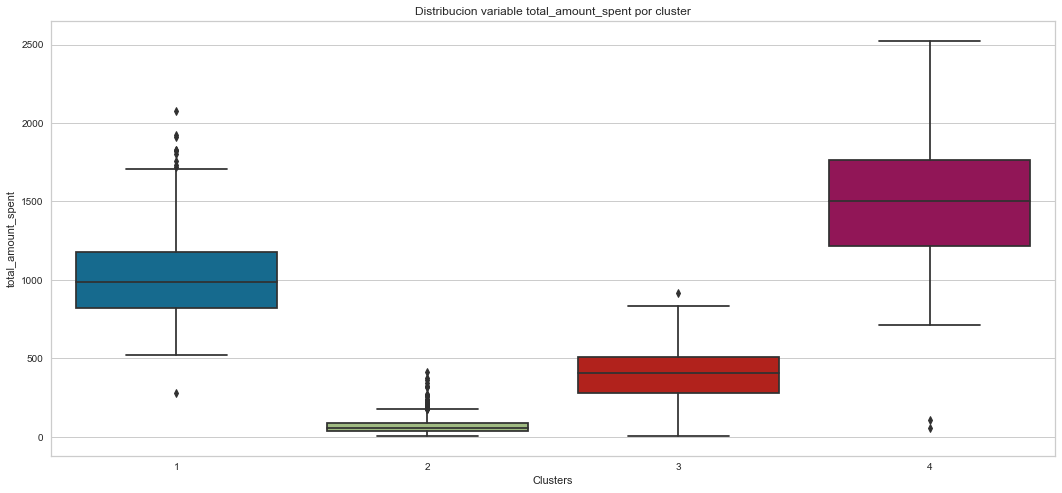

In [48]:
boxplot_per_cluster('total_amount_spent')

,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods
Clusters,,,,,,
1,256315,18542,101561,25789,19806,32237
2,23172,3696,14847,5104,3788,11958
3,104069,7953,39658,10944,7845,21083
4,291740,28050,213404,41442,28388,31886


<AxesSubplot:title={'center':'Principal gasto por cluster en los ultimos 2 años'}, xlabel='Clusters'>

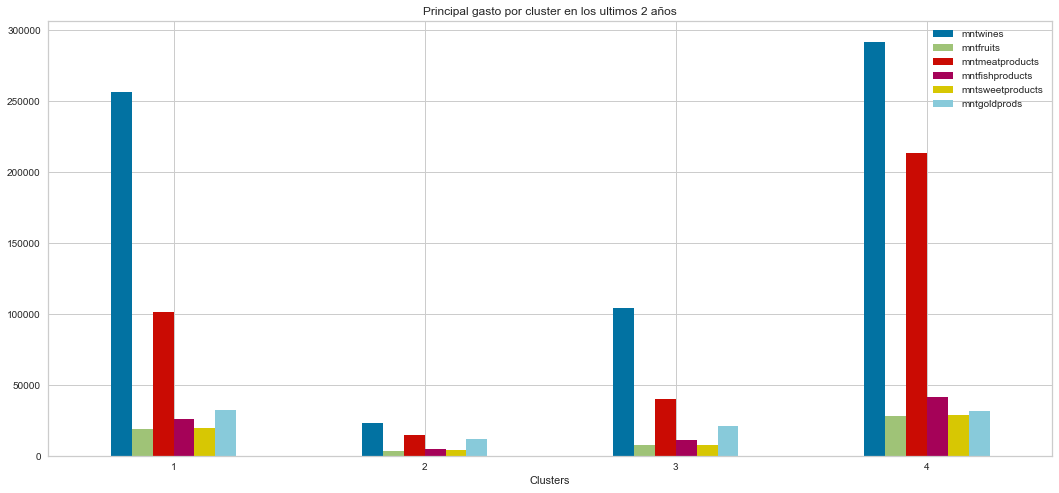

In [49]:
display(df.groupby('Clusters')[['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']].sum())
df.groupby('Clusters')[['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']].sum().plot(kind='bar', figsize=(18,8), rot=0, title='Principal gasto por cluster en los ultimos 2 años')

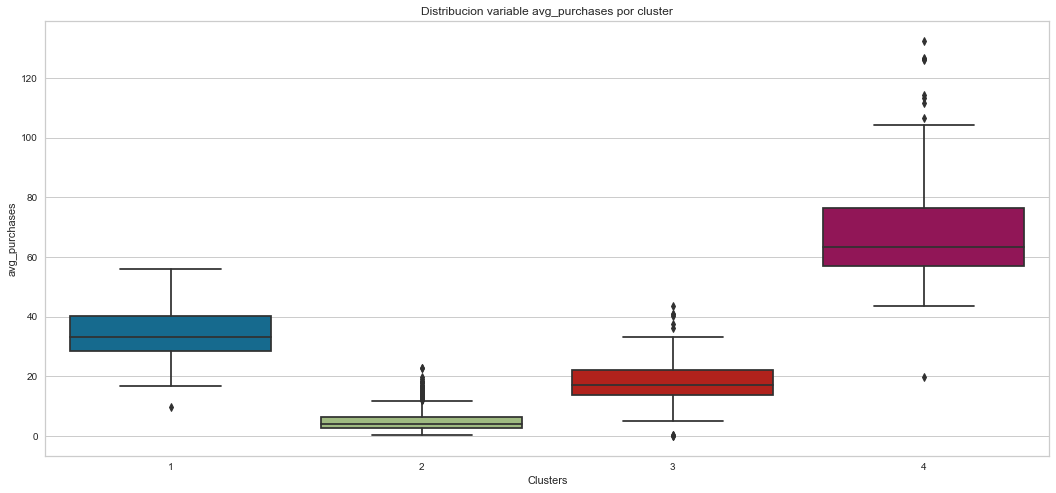

In [52]:
boxplot_per_cluster('avg_purchases')

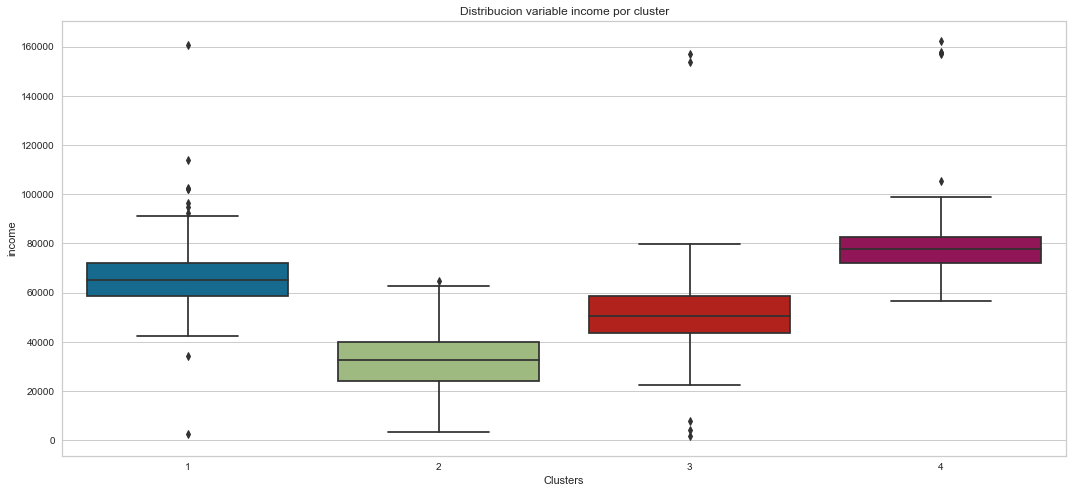

In [50]:
boxplot_per_cluster('income')

### Perfilado de clusters

- **Cluster 1:**
	- Cluster de clientes casados o solteros
	- Clientes con estudios.
	- Es el cluster de clientes que mas compra en tienda y en web. 
	- Cluster de clientes que mas cantidad de compras realiza. 
	- Pueden aceptar alguna campaña pero generalmente no la aceptan. 
	- Son clientes con 1 hijo.
	- El gasto total es superior a la media. Principalmente en vino o carne. 
	- El gasto promedio es superior a la media. 
	- Cluster con los clientes con ingresos altos. 
	
- **Cluster 2:**
	- Cluster de clientes casados. 
	- Con estudios pero muchos de ellos sin estudios.
	- Clientes que mas visitas a la web realizan y utilizan descuentos, las compras realizadas son por tienda.
	- Cluster de clientes que menos compras realiza.
	- Cluster de clientes que no acepta campañas.
	- Clientes que en su mayoría tienen más de 1 un hijo. 
	- Cluster que menos gasta en compras. El promedio de gasto por compra es el más bajo.
	- Cluster con menos ingresos. 
	
- **Cluster 3:**
	- Cluster de clientes casados o solteros
	- Clientes con estudios.
	- Segundo cluster con más visitas a la web de la compañia, realiza compras principalmente en la tienda y por internet. 
	- Cluster con un número de compras relativamente elevado. 
	- Cluster de clientes que no aceptan campañas. 
	- Cluster de clientes con 1 o 2 hijos. 
	- Es el segundo cluster que menos cantidad ha gastado. 
	- El gasto promedio es el segundo más bajo. 
	- Clientes con unos ingresos promedios. 

- **Cluster 4:**
	- Cluster de clientes casados o solteros
	- Clientes con estudios.
	- Cluster de clientes que menos visitas a la web realizan, compran tanto por tienda, catalogo e internet. Son los clientes que menos promociones cogen. 
	- Cluster con un número de compras promedio.
	- Cluster de clientes que mas campañas aceptan.
	- Cluster de clientes sin hijos.
	- Es el cluster que mas gastos realiza. Principalmente en vino y carne. 
	- El gasto promedio es el más elevado. 
	- Es el cluster con los ingresos más altos. 

**Conclusiones:**
- Cluster 1: Clientes con ingresos altos, son los clientes que más cantidad de compras realizan con un gasto promedio por compra superior a la media, las compras son realizadas principalmente por tienda o por la web. Pueden aceptar alguna campaña pero generalmente no la aceptan. 
- Cluster 2: Clientes con menos ingresos con 1 ó 2 hijos, son los clientes que menos gastan en compras aunque son los clientes que mas visitan la web de la compañia. 
- Cluster 3: Cluster con ingresos promedios, el gasto promedio por compra es de los más bajos pero el número de compras realizadas es relativamente alto, no aceptan campañas pero es el segundo cluster con más visitas a la web. 
- Cluster 4: Es el cluster con más ingresos, que más cantidad se ha gastado en las compras con un número de compras promedio, el gasto promedio por compra es muy elevado. Aceptan campañas y no visitan la web de la compañia. 